In [238]:
import pandas as pd
import json
import tweepy as tw
import configparser
import numpy as np
import re

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

#Conexão com o MongoDb
from pymongo import MongoClient


## CONECTANDO AO config.ini

In [264]:
config = configparser.ConfigParser()
config.read("config.ini")

['config.ini']

## CONECTANDO AO BD ELEICOES2022

In [265]:
mongo = config["mongodb"]["mongo"]

In [266]:
#conectando ao mongoDB
client_db = MongoClient(mongo)

In [267]:
#Conectando ao banco de dados eleicoes2022
db = client_db.get_database("eleicoes2022_db")

In [268]:
#CONECTANDO AO COLLECTION NAME TWEETS
collection_tweets = db.tweets

## CONECTANDO AO TWITTER

In [ ]:
api_key = config["twitter"]["api_key"]
api_key_secret = config["twitter"]["api_key_secret"]
access_token = config["twitter"]["access_token"]
access_token_secret = config["twitter"]["access_token_secret"]

In [ ]:
#Authentication
auth = tw.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth)

In [ ]:
# tw.Cursor(api.search_tweets)

In [ ]:
# #teste de conexão - home-timeline
# public_tweets = api.home_timeline()
# for tweet in public_tweets:
#     print(tweet.text)

## PESQUISANDO #ELEICOES2022

In [ ]:
# search_words = "#Eleições2022"
query_words = "#Eleições2022 #Eleicoes2022" + "-filter:retweets" 

In [ ]:
#Escolhendo tema especifico
tweets = tw.Cursor(api.search_tweets,
                    q = query_words).items(1000)

In [ ]:
# for tweet in tweets:
#     print(tweet.created_at)
#     print(tweet.text)

In [ ]:
# tweets_dict = {}
# tweets_dict = tweets_dict.fromkeys(tweet._json.keys())
# type(tweets_dict)

In [ ]:
lista_tweets = []
for tweet in tweets:
    data = tweet._json
    tweets_dict = {key : value for key, value in data.items()}
    lista_tweets.append(tweets_dict)

In [ ]:
#CRIANDO DF_TWEETS
df_tweets = pd.DataFrame.from_dict(lista_tweets)

In [ ]:
df_tweets.shape

In [ ]:
df_tweets.info()

In [ ]:
df_tweets.columns

In [ ]:
#SELECIONANDO COLUNAS MAIS RELEVANTES
df_tweets_short = df_tweets[['created_at','text', 'truncated',
       'metadata', 'source', "user", 'retweet_count', 'retweeted', 'lang']]

In [ ]:
#EXCLUINDO LINKS NA FEATURE TEXT
for idx, texto in enumerate(df_tweets_short["text"]):
    padrao = re.compile('https:.+')
    if padrao.findall(texto):
        https = padrao.findall(texto)
        df_tweets_short["text"][idx] = df_tweets_short["text"][idx].replace(https[0], "")

In [ ]:
pd.options.display.max_colwidth = 130
df_tweets_short["text"]

In [ ]:
#CRIANDO FEATURE USUARIO
df_tweets_short["usuario"] = np.nan
for idx in df_tweets_short.index:
    df_tweets_short["usuario"][idx] = df_tweets_short["user"][idx]["screen_name"]

In [ ]:
#EXCLUINDO CARACTERES \n (caracter de quebra de linha)
for idx, texto in enumerate(df_tweets_short["text"]):
    df_tweets_short["text"][idx] =  texto.replace("\n", "")

In [ ]:
df_tweets_short = df_tweets_short[['created_at','text', 'truncated',
       'metadata', 'source', 'retweet_count', 'retweeted', 'lang']]

## TRANSFORMAR JSON E SALVANDO NO BD

In [239]:
df_tweets_short.to_json("json_tweets.json", orient = "index")

In [248]:
# with open('json_tweets.json') as f:
#   json_tweets = json.load(f)

#   collection_tweets.insert_many(json_tweets.values())

## IMPORTANDO JSON DO BD

In [250]:
tweets = pd.DataFrame(list(collection_tweets.find()))

In [251]:
tweets.head()

,_id,created_at,text,truncated,metadata,source,retweet_count,retweeted,lang
0,637664440188e2ffa271a2ed,Thu Nov 17 14:42:43 +0000 2022,"In Brazil And U.S., Elections As Stress Tests For Democracy#politics #brazil #UnitedStates #democracy #eleições…",True,"{'iso_language_code': 'en', 'result_type': 'recent'}","<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",0,False,en
1,637664440188e2ffa271a2ee,Thu Nov 17 14:42:42 +0000 2022,Continuamos na luta! #brazilwasstollen #Eleicoes2022,False,"{'iso_language_code': 'pt', 'result_type': 'recent'}","<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",0,False,pt
2,637664440188e2ffa271a2ef,Thu Nov 17 14:36:46 +0000 2022,Veja a lista de 43 pessoas físicas e jurídicas suspeitas de financiar atos antidemocráticos (Piada pronta):.09 -…,True,"{'iso_language_code': 'pt', 'result_type': 'recent'}","<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",0,False,pt
3,637664440188e2ffa271a2f0,Thu Nov 17 14:36:27 +0000 2022,É a política no Brasil tá como? #Politica #Brasil #Eleicoes2022 @iRodolffo te explica melhor 😂😂😂🧨🔫🖋️🔪💸🚜🥊🏹🍕🥩🍳🐀🐄,False,"{'iso_language_code': 'pt', 'result_type': 'recent'}","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",0,False,pt
4,637664440188e2ffa271a2f1,Thu Nov 17 14:25:43 +0000 2022,@Seondetails #PERDEUMANÉ#LulaJá #LulaPresidente #Lula2022 #Lula#Eleições2022 #Eleiçoes22 #Brasil#FORABOLSONARO…,True,"{'iso_language_code': 'und', 'result_type': 'recent'}","<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",0,False,und


## CRIANDO NUVEM DE PALAVRAS

In [252]:
#Transformando o texto em uma unica string
string = pd.Series(tweets["text"].values).str.cat(sep = ' ')

In [253]:
# removendo caracteres especiais
caracteres = "#@"

for i in range(len(caracteres)):
    string = string.replace(caracteres[i], "")

In [254]:
#tranformando tudo em letra minuscula 
string = string.lower()

In [269]:
#criando stopwords
stopwords = set(STOPWORDS)
stopwords.update(["eleicoes2022", "eleições2022", "eleiçoes2022", "nem", "dia", "sua", "está", "por","de",'dar','pois','em','um','da','ser','aqui','vou','dos','ter','não','ao','sou','seu','à','n','se','esse','uma','mais','ele','fazendo','você','pode','essa','é','mas','segue','pra','isso','vez','para','muito','pelo','pela','são', 'na','vamos','https','t','co','c','New','eu','seis','retweets','ano','pessoa','likes', "nos", "já", "há", "até", "foi", "como", "quem", "cada","lá", "sem", 'vai','que','ou', "muita", "das", "bem", 'anos','7dias','tirou','tem','q','0','O','e','os','assim','só','mesmo','tá','pro','votar','pessoas','vc'])

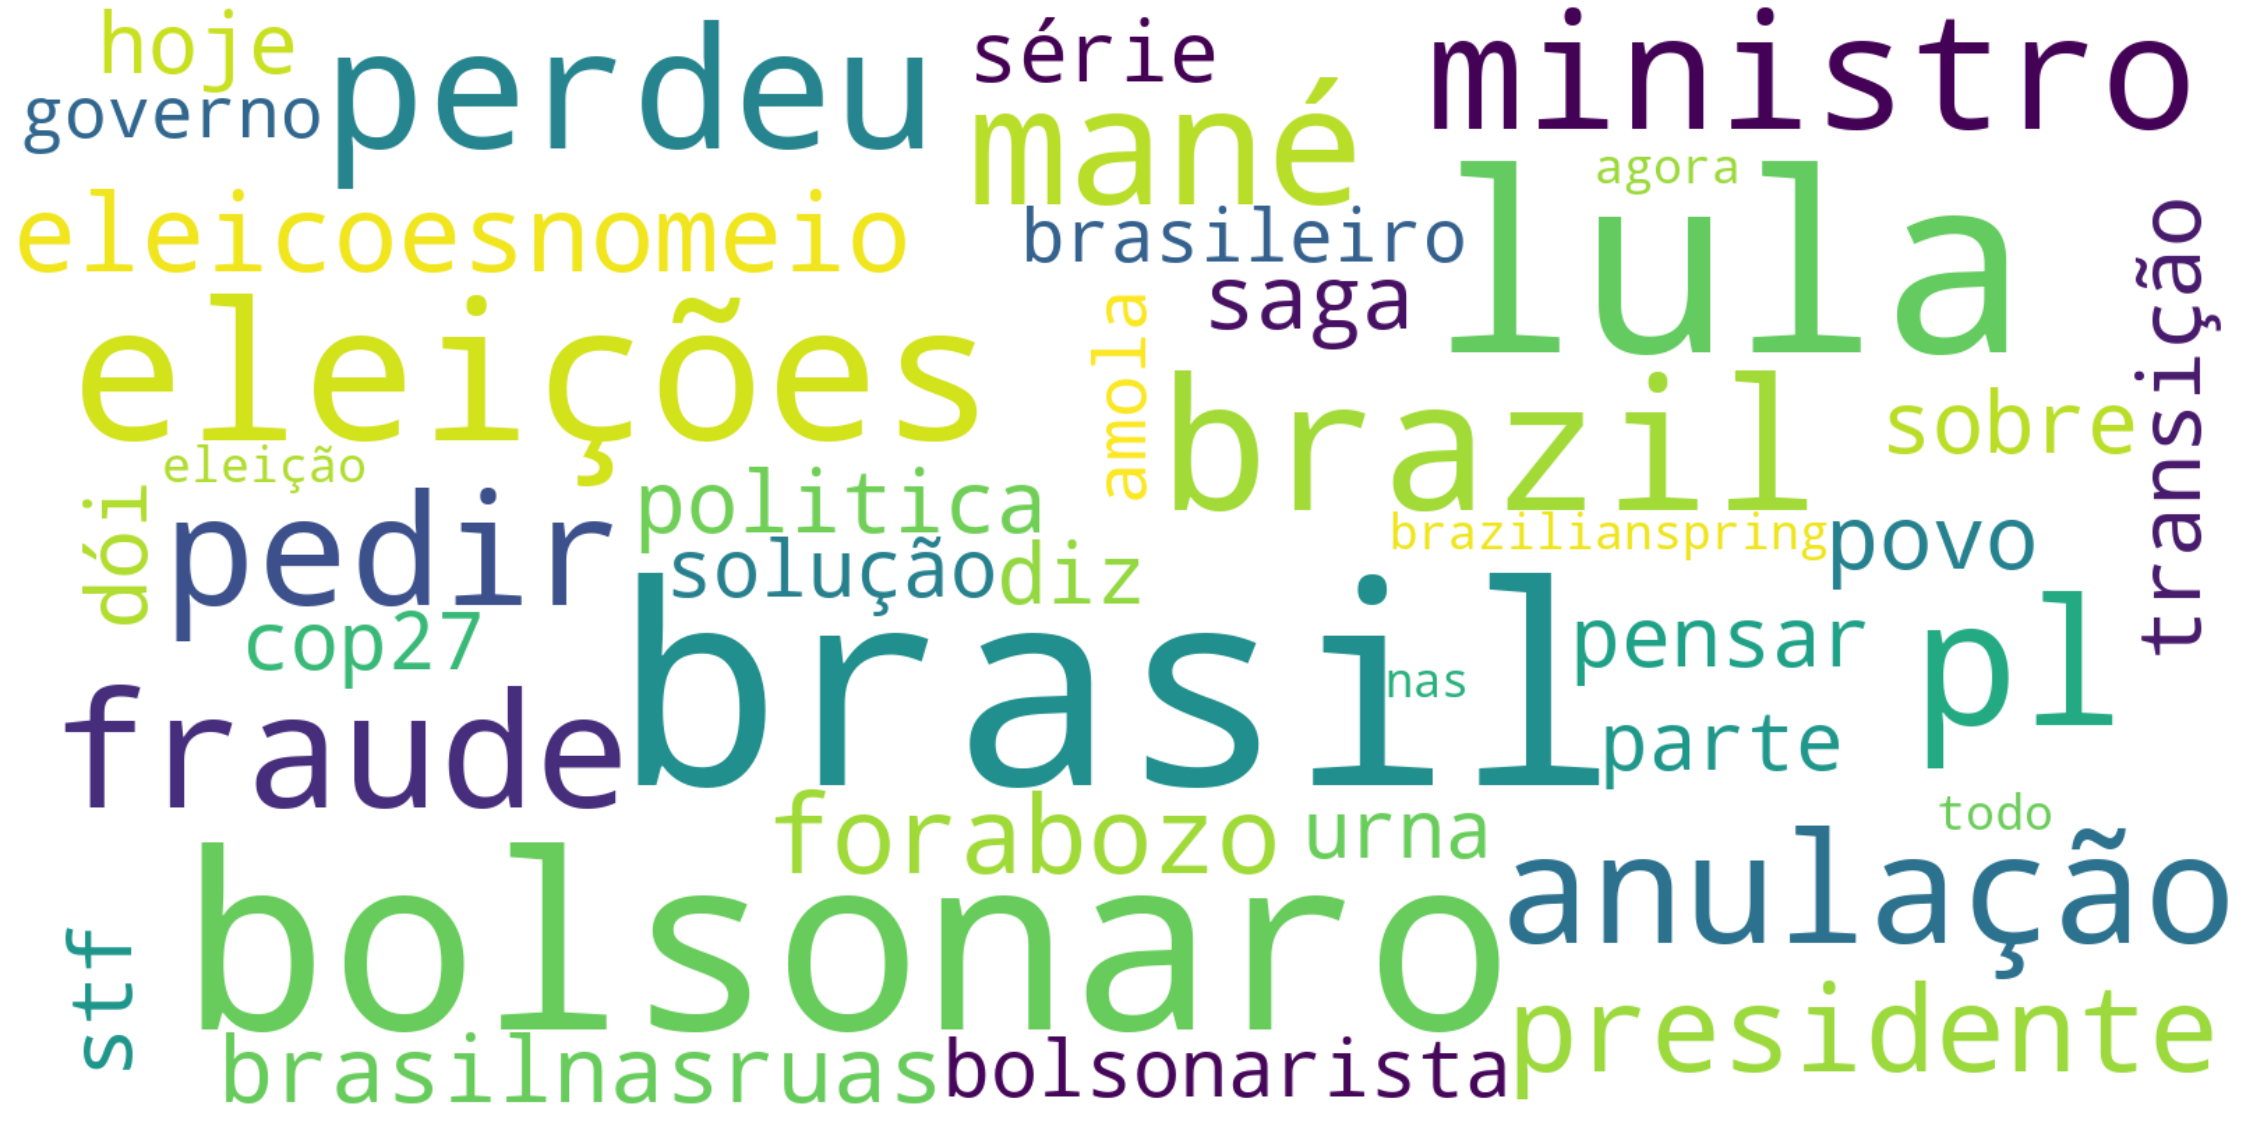

In [270]:
# Word Cloud com os textos dos tweets
wordcloud = WordCloud(width=1600, stopwords=stopwords, height=800,max_font_size=200, max_words=40,collocations=False, background_color='white').generate(string)
plt.figure(figsize=(40,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()